## Kernel Regression



### Conditional expectations



We address the following problem.  There exists a random variable $y$
with conditional expectation $E(y|x)$  which is continuous in
$x$ (further, if $x$ is random then the density of $x$, $f(x)>0$).
For example (play!):



In [1]:
import numpy as np

def m(x): return np.sin(2*x)/(1+x)

Plot the conditional expectation:



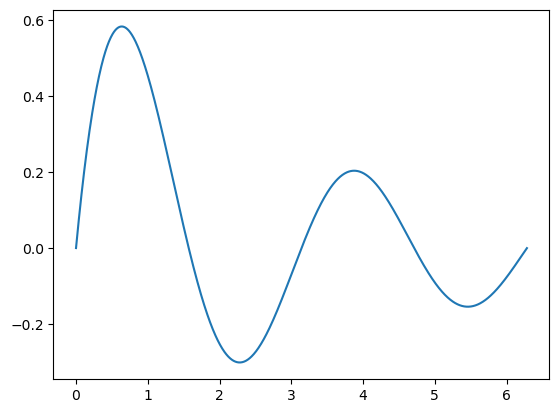

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

V = np.linspace(1e-4,2*np.pi,1000)

ax = plt.plot(V,m(V))

### Sample



Now, suppose we don&rsquo;t know $m$ or the conditional distribution of $y$,
but we can draw a sample of realizations, which we&rsquo;ll put in a `pandas.Series`.



In [3]:
import pandas as pd
from scipy.stats import distributions as iid

X = iid.uniform(V.min(),V.max())  # Handy to have bounded support, but not necessary

U = iid.norm(scale=0.1) # Scale=std. dev.  Play!

n = 1000 # Sample size

x = pd.Series(X.rvs(size=n))

# Series are imperial when they can be:
y = m(x) + U.rvs(size=n)  

type(y)

pandas.core.series.Series

Now let&rsquo;s take an informal look at the data:



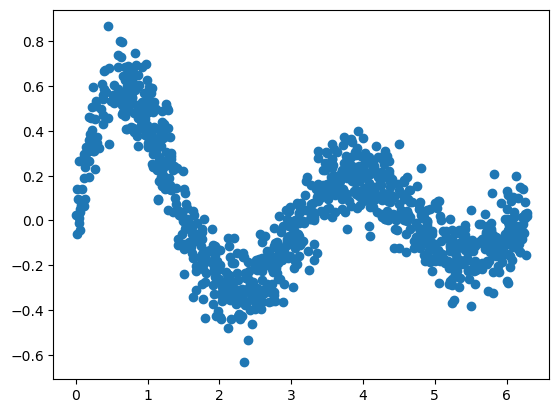

In [4]:
plt.scatter(x,y)

How can we use this random sample to estimate $m$?  The scatterplot
suggests that some kind of local smoothing might help.



### Estimator



Let&rsquo;s go ahead and define the kernel regression estimator, following
the same general logic as in our exploration of kernel densities.

Start by defining a kernel:



In [5]:
sqrt3 = np.sqrt(3)  # Avoid repeated evaluation of this for speed...

k = lambda u: (np.abs(u) < sqrt3)/(2*sqrt3)  # Rectangular kernel

# k = lambda u: np.exp(-(u**2)/2)/np.sqrt(2*np.pi) # Gaussian kernel

Now define the kernel estimator:



In [6]:
def kernel_regression(X,y,h):
    """
    Use data (X,y) to estimate E(y|x), using bandwidth h.
    """
    def mhat(x):
        S = k((X-x)/h) # "Smooths"

        return S.dot(y)/S.sum()

    return mhat

We already have a random sample: let&rsquo;s try using it to estimate $m$:



In [7]:
mhat = kernel_regression(x,y,h=0.3) 

mhat(1)  # Try to evaluate at a point

0.39498424916301483

Now graph our estimate



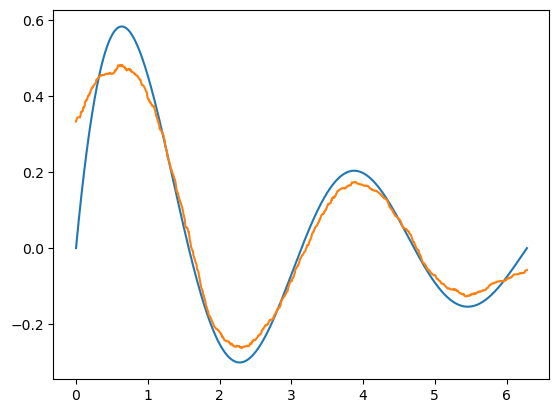

In [8]:
fig,ax = plt.subplots()

ax.plot(V,[m(v) for v in V])  # "Truth"
ax.plot(V,[mhat(v) for v in V]) # Estimate

### Leave-one out cross-validation



We talked about computing estimates $m_{-i}$ to estimate the IMSE.
   Doing this directly would require $n$ separate estimations.  This
   is expensive!

A little algebra suggests an alternative, involving the &ldquo;Gram&rdquo; matrix.



In [9]:
def leave_out_residuals(X,y):
    """
    Use data (X_{-j},y_{-j}) to estimate E(y|x), using bandwidth h.
    """
    
    def Gram_matrix(X,h):
        """
        Define kernel-data matrix [ k((x_i-x_j)/h) ]
        """
        v = np.array(X).reshape((-1,1)) # Column vector

        return k((v-v.T)/h) 

    def ecv(h):
        """
        Leave-out residuals as fn of bandwidth h.
        """
        G = Gram_matrix(X,h)
        G0 = G - np.diag(np.diag(G)) # Zero out diagonals

        e = y - (G0@y)/np.sum(G0,axis=1)

        return e

    return ecv

Consider the &ldquo;leave-one-out&rdquo; or &ldquo;Cross-Validation&rdquo; residuals:



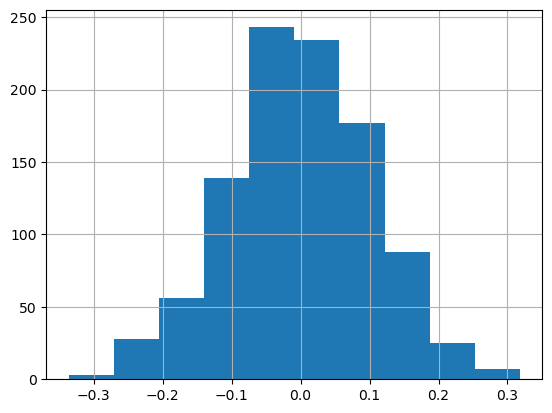

In [10]:
ecv = leave_out_residuals(x,y)

ax = ecv(h=0.1).hist()

Define an estimator of the IMSE as a function of the bandwidth $h$:



In [11]:
def imse_cv(h):
    return np.mean(ecv(h)**2)

imse_cv(.5)

0.021355780085809822

Try plotting esimated IMSE as a function of bandwidth:



/tmp/ipykernel_10243/3675371147.py:21: RuntimeWarning: invalid value encountered in divide
  e = y - (G0@y)/np.sum(G0,axis=1)


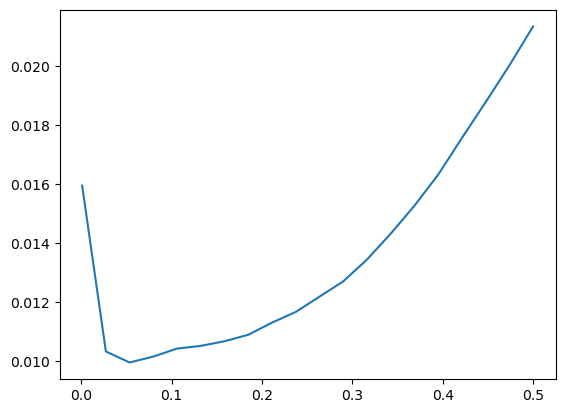

In [12]:
H = np.linspace(1e-3,.5,20)

plt.plot(H,[imse_cv(h) for h in H])

Actually find the minimum:



In [13]:
from scipy.optimize import minimize_scalar

soltn = minimize_scalar(imse_cv,bounds=[1e-2,1])

if soltn.success:
    hstar = soltn.x
    print(soltn)

 message: Solution found.
 success: True
  status: 0
     fun: 0.009929375015412524
       x: 0.05388776205018424
     nit: 20
    nfev: 20


Now, estimate using estimated optimal bandwidth:



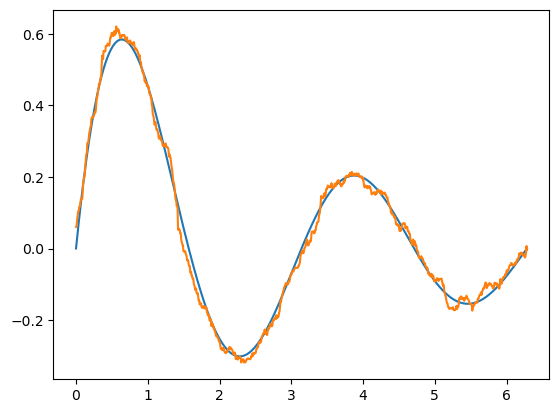

In [14]:
mhat = kernel_regression(x,y,hstar)

fig,ax = plt.subplots()

ax.plot(V,[m(v) for v in V])  # "Truth"
ax.plot(V,[mhat(v) for v in V]) # Estimate